<a href="https://colab.research.google.com/github/greymouse1/spatialanalysis/blob/main/continuity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code is licenced under MIT licence.

Author: Nikola G.

Credits:

Tutorial from Momepy package website at http://docs.momepy.org/en/stable/user_guide/graph/coins.html
based on paper by Tripathy et al. (2020)

OpenAI. (2024). ChatGPT (version 4) [Large language model]. OpenAI. https://openai.com/chatgpt



Tripathy, P., Rao, P., Balakrishnan, K., & Malladi, T. (2020). An open-source tool to extract natural continuity and hierarchy of urban street networks. Environment and Planning B: Urban Analytics and City Science. http://dx.doi.org/10.1177/2399808320967680

In [ ]:
!pip install osmnx > /dev/null 2>&1
!pip install momepy > /dev/null 2>&1
!pip install mapclassify>=2.4.0 > /dev/null 2>&1 # install mapclassify with version >=2.4.0
import osmnx as ox
import geopandas as gpd
import momepy

In [ ]:
# Load shp file with city polygon boundary (WGS84)

bandung_pol = gpd.read_file("/content/bandung_pol/bandung_pol.shp").geometry.iloc[0]

In [ ]:
# Retrieve the graph within the polygon's boundaries
# This will pull OSM data from inside the polygon and create a networkX graph

graph = ox.graph_from_polygon(
    bandung_pol,
    network_type='drive',  # Choose network type (e.g., 'drive', 'walk', 'bike', etc.)
    simplify=True,         # Simplify graph (remove unnecessary nodes)
    retain_all=False,      # Keep only the largest connected component
    truncate_by_edge=False  # Truncate by edge to keep nodes near the edge
)


In [ ]:
# Reproject graph
# Choice of final projection is automatic, original must be WGS84

bandung_streets = ox.projection.project_graph(graph)

In [ ]:
# Create gdf from graph so it can be used later on

bandung_gdf = ox.graph_to_gdfs(
    ox.convert.to_undirected(bandung_streets),
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True,
)

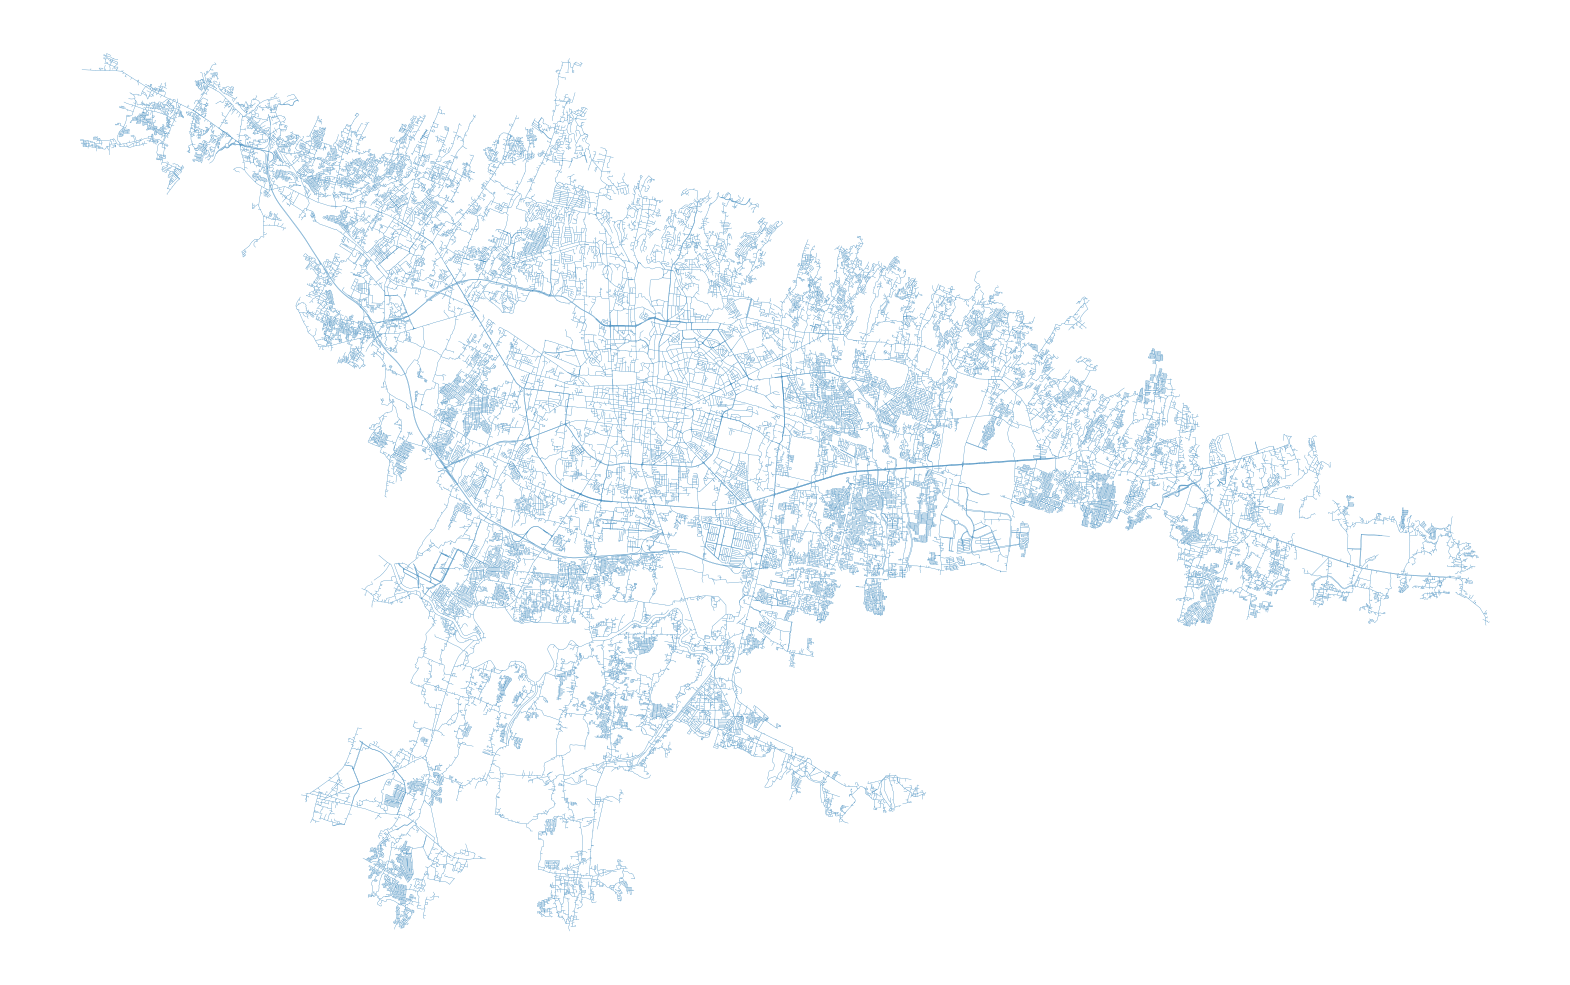

In [ ]:
# Plot downloaded OSM roads

bandung_gdf.plot(figsize=(20, 20), linewidth=0.2).set_axis_off()

In [ ]:
# Calculate continuity from the gdf

continuity = momepy.COINS(bandung_gdf, angle_threshold=135, flow_mode=False)

In [ ]:
# Pull out stroke

bandung_stroke_gdf = continuity.stroke_gdf()

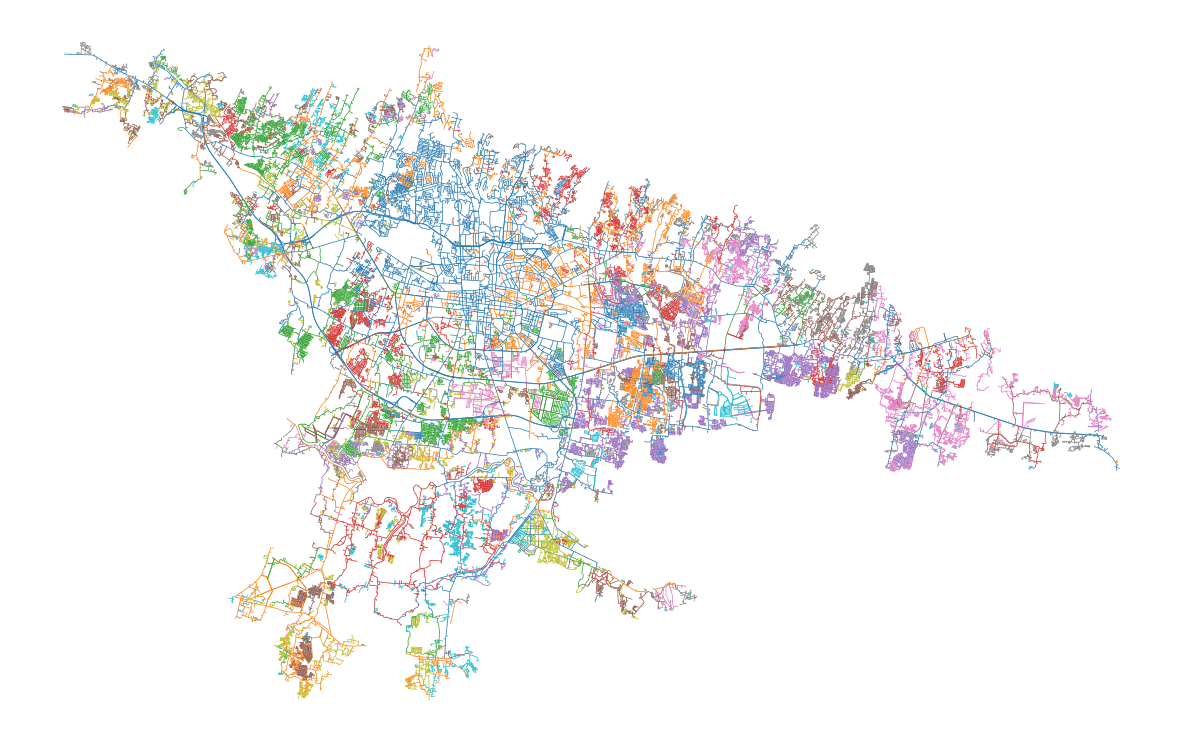

In [ ]:
# Plot stroke by length

bandung_stroke_gdf.plot(
    figsize=(15, 15),
    cmap="tab10",
    linewidth=0.5,
    scheme="headtailbreaks"
).set_axis_off()

Classification Bins:
   Bin  Lower Bound  Upper Bound
0    1     7.227679    19.576044
1    2    19.576044    41.652383
2    3    41.652383    83.757252
3    4    83.757252   148.326531
4    5   148.326531   234.000000
5    6   234.000000   303.961538
6    7   303.961538   358.166667
7    8   358.166667   405.800000
8    9   405.800000   424.666667
9   10   424.666667   434.000000


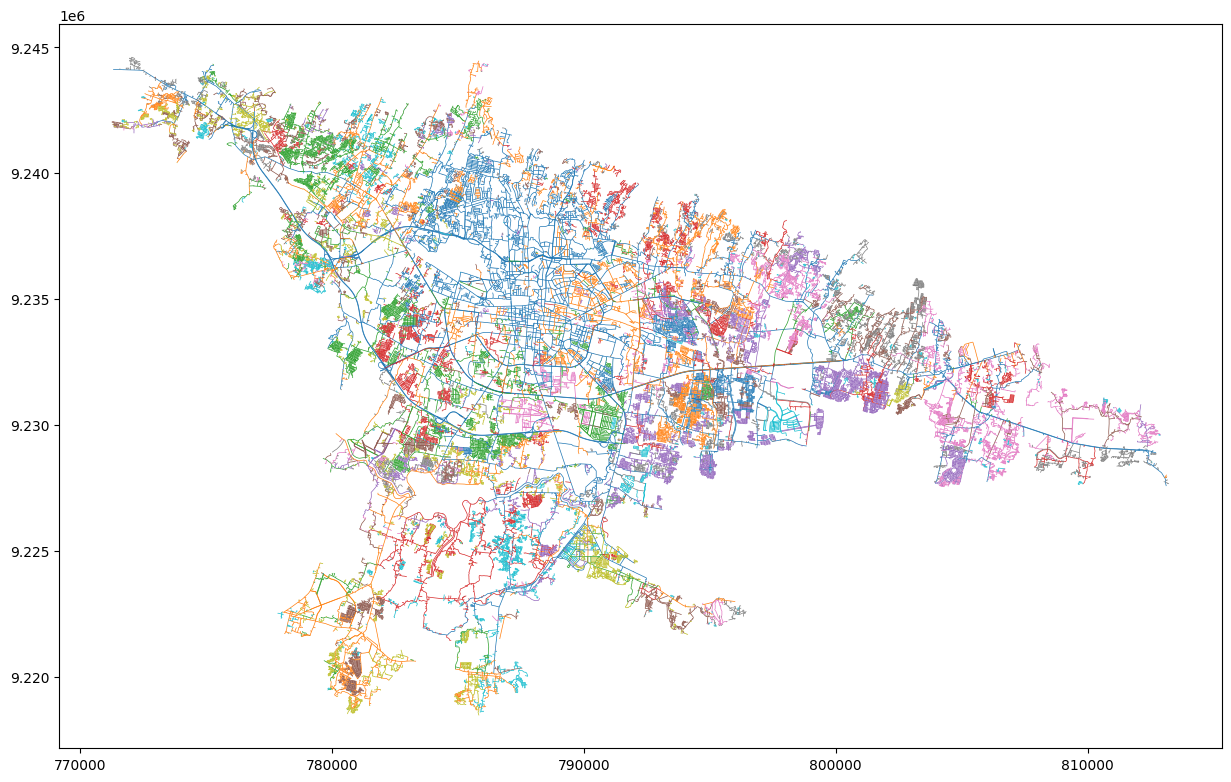

In [ ]:
import geopandas as gpd
import mapclassify
import matplotlib.pyplot as plt
import pandas as pd



# Step 1: Pull 'n_segments' (or some attribute column) from the GeoDataFrame
# Assuming 'n_segments' is an attribute column in your GeoDataFrame
n_segments = bandung_stroke_gdf['n_segments']  # Replace with actual column name

# Step 2: Apply headtailbreaks classification for a heavy tail distribution
classifier = mapclassify.HeadTailBreaks(n_segments)  # k is the number of bins

# Step 3: Show the table of classification breaks
breaks_table = pd.DataFrame({
    'Bin': range(1, len(classifier.bins)),
    'Lower Bound': classifier.bins[:-1],
    'Upper Bound': classifier.bins[1:]
})

print("Classification Bins:")
print(breaks_table)

# Step 4: Plotting the data on a map with discrete color limits based on classification
fig, ax = plt.subplots(figsize=(15, 15))

# Plot the GeoDataFrame with color scheme based on the classification
bandung_stroke_gdf.plot(
    ax=ax,
    cmap="tab10",  # Use a discrete colormap
    linewidth=0.5,
    scheme="user_defined",  # Use user-defined classification scheme
    classification_kwds={'bins': classifier.bins},  # Use the bins from the classifier
    legend=True,  # Enable the legend
    legend_kwds={'label': "n_segments", 'orientation': "horizontal"}  # Customize legend
)

# Show the plot
plt.show()


In [ ]:
bandung_stroke_gdf



,n_segments,geometry
stroke_group,,
0,51,"LINESTRING (789664.916 9235489.547, 789683.549..."
1,421,"LINESTRING (784756.281 9234601.336, 784774.294..."
2,2,"LINESTRING (790299.152 9235268.608, 790242.376..."
3,4,"LINESTRING (790435.24 9235276.112, 790432.323 ..."
4,57,"LINESTRING (789224.433 9234033.298, 789245.052..."
...,...,...
36037,1,"LINESTRING (785650.41 9243023.286, 785645.69 9..."
36038,1,"LINESTRING (793888.174 9232589.076, 793838.843..."
36039,1,"LINESTRING (807930.6 9228824.601, 807924.234 9..."


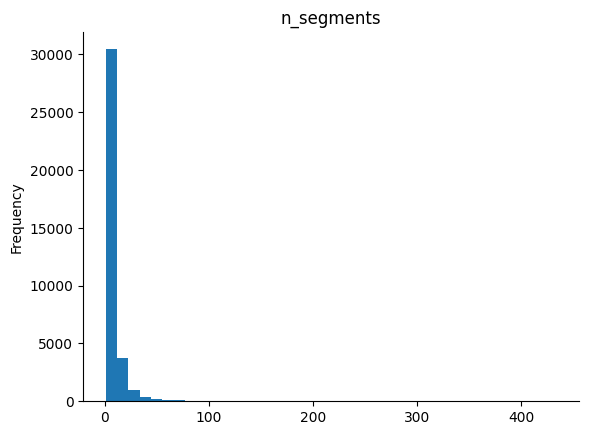

In [ ]:
# @title n_segments

from matplotlib import pyplot as plt
bandung_stroke_gdf['n_segments'].plot(kind='hist', bins=40, title='n_segments')
plt.gca().spines[['top', 'right',]].set_visible(False)